In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 31 11:48:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   45C    P0    31W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6387481919955462
GPU (s):
0.03147388900106307
GPU speedup over CPU: 20x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(img_dir, preprocess):

  data_dir = pathlib.Path(img_dir)

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if preprocess == True:
    x = tf.keras.applications.densenet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
51888128/51877672 [==============================] - 42s 1us/step
Using preprocessing
Epoch 1/100
360/360 [==============================] - 33s 63ms/step - loss: 0.8652 - accuracy: 0.6610 - val_loss: 0.6764 - val_accuracy: 0.6968
Epoch 2/100
360/360 [==============================] - 18s 51ms/step - loss: 0.6763 - accuracy: 0.7153 - val_loss: 0.6445 - val_accuracy: 0.7286
Epoch 3/100
360/360 [==============================] - 18s 49ms/step - loss: 0.6428 - accuracy: 0.7282 - val_loss: 0.6141 - val_accuracy: 0.7398
Epoch 4/100
360/360 [==============================] - 17s 48ms/step - loss: 0.6327 - accuracy: 0.7355 - val_loss: 0.6002 - val_accuracy: 0.7487
Epoch 5/100
360/360 [==============================] - 17s 47ms/step - loss: 0.6159 - accuracy: 0.7426 - val_loss: 0.5909 - val_accuracy: 0.7553
Epoch 6/100
360/360 [===================

360/360 [==============================] - 16s 45ms/step - loss: 0.5027 - accuracy: 0.7979 - val_loss: 0.5418 - val_accuracy: 0.7747
Epoch 55/100
360/360 [==============================] - 17s 46ms/step - loss: 0.4957 - accuracy: 0.7974 - val_loss: 0.5428 - val_accuracy: 0.7807
Epoch 56/100
360/360 [==============================] - 16s 46ms/step - loss: 0.4996 - accuracy: 0.7947 - val_loss: 0.5611 - val_accuracy: 0.7741
Epoch 57/100
360/360 [==============================] - 16s 45ms/step - loss: 0.4961 - accuracy: 0.7976 - val_loss: 0.5368 - val_accuracy: 0.7874
Epoch 58/100
360/360 [==============================] - 16s 45ms/step - loss: 0.4954 - accuracy: 0.7954 - val_loss: 0.5467 - val_accuracy: 0.7727
Epoch 59/100
360/360 [==============================] - 16s 45ms/step - loss: 0.4908 - accuracy: 0.7982 - val_loss: 0.5349 - val_accuracy: 0.7836
Epoch 60/100
360/360 [==============================] - 17s 46ms/step - loss: 0.4958 - accuracy: 0.7963 - val_loss: 0.5314 - val_accuracy

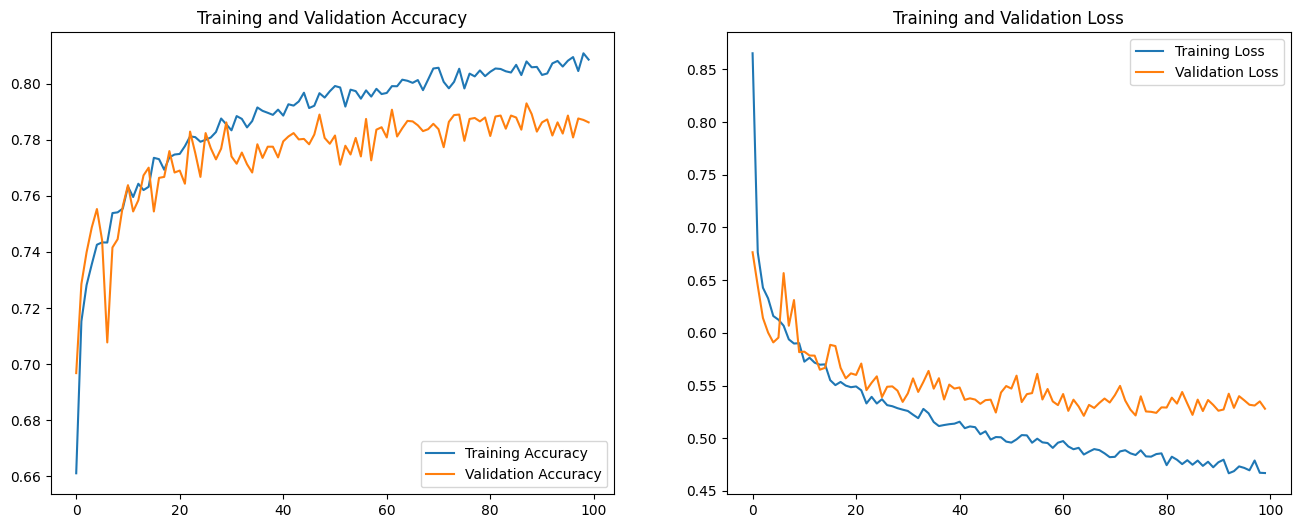

In [5]:
res_hls_pre = train_model('content/img_HLS', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 30s 55ms/step - loss: 4.0841 - accuracy: 0.3912 - val_loss: 1.0768 - val_accuracy: 0.5273
Epoch 2/100
360/360 [==============================] - 18s 49ms/step - loss: 1.2390 - accuracy: 0.4807 - val_loss: 1.0878 - val_accuracy: 0.5085
Epoch 3/100
360/360 [==============================] - 18s 49ms/step - loss: 1.1358 - accuracy: 0.5120 - val_loss: 1.0402 - val_accuracy: 0.5198
Epoch 4/100
360/360 [==============================] - 17s 48ms/step - loss: 1.0781 - accuracy: 0.5328 - val_loss: 1.0244 - val_accuracy: 0.5637
Epoch 5/100
360/360 [==============================] - 17s 47ms/step - loss: 1.0302 - accuracy: 0.5549 - val_loss: 0.9984 - val_accuracy: 0.5776
Epoch 6/100
360/360 [==============================] - 17s 48ms/step - loss: 1.0171 - accuracy: 0.5615 - val_loss: 1.0878 - va

360/360 [==============================] - 17s 46ms/step - loss: 0.9047 - accuracy: 0.6083 - val_loss: 0.8696 - val_accuracy: 0.6325
Epoch 57/100
360/360 [==============================] - 17s 47ms/step - loss: 0.9066 - accuracy: 0.6050 - val_loss: 0.9024 - val_accuracy: 0.6141
Epoch 58/100
360/360 [==============================] - 16s 45ms/step - loss: 0.9326 - accuracy: 0.5875 - val_loss: 0.9010 - val_accuracy: 0.5927
Epoch 59/100
360/360 [==============================] - 16s 46ms/step - loss: 0.9343 - accuracy: 0.5911 - val_loss: 0.9746 - val_accuracy: 0.5702
Epoch 60/100
360/360 [==============================] - 16s 46ms/step - loss: 0.9375 - accuracy: 0.5888 - val_loss: 0.9538 - val_accuracy: 0.5790
Epoch 61/100
360/360 [==============================] - 17s 46ms/step - loss: 0.9275 - accuracy: 0.5986 - val_loss: 0.9367 - val_accuracy: 0.5821
Epoch 62/100
360/360 [==============================] - 17s 47ms/step - loss: 0.9193 - accuracy: 0.5970 - val_loss: 0.9110 - val_accuracy

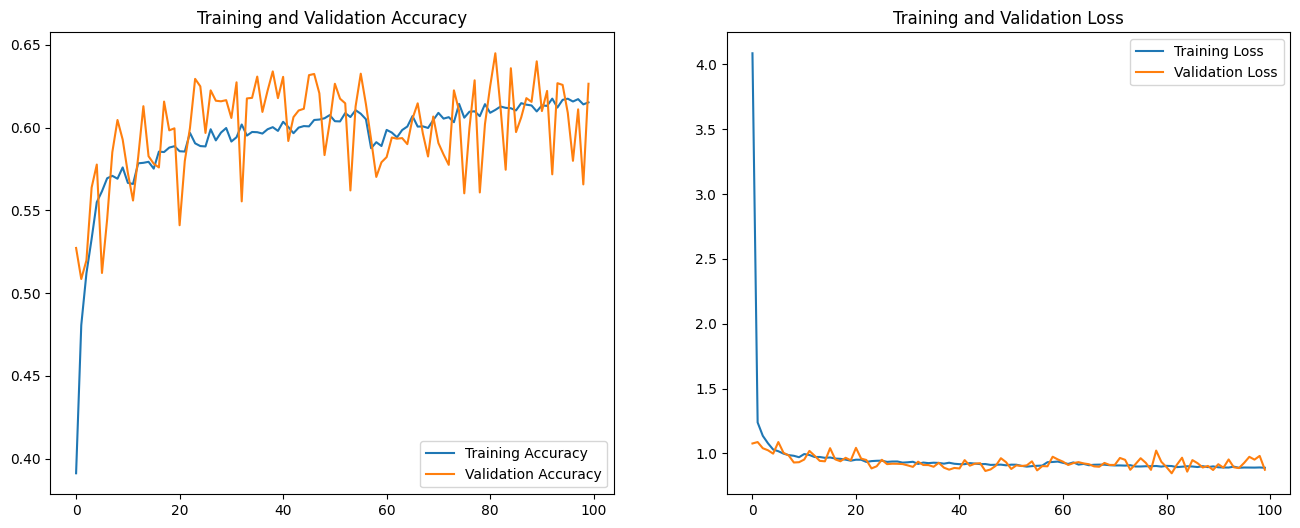

In [6]:
res_hls_nonpre = train_model('content/img_HLS', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 29s 53ms/step - loss: 0.6964 - accuracy: 0.7151 - val_loss: 0.5221 - val_accuracy: 0.7801
Epoch 2/100
360/360 [==============================] - 17s 48ms/step - loss: 0.5687 - accuracy: 0.7592 - val_loss: 0.5104 - val_accuracy: 0.7923
Epoch 3/100
360/360 [==============================] - 18s 49ms/step - loss: 0.5350 - accuracy: 0.7750 - val_loss: 0.4969 - val_accuracy: 0.7944
Epoch 4/100
360/360 [==============================] - 17s 48ms/step - loss: 0.5166 - accuracy: 0.7829 - val_loss: 0.4628 - val_accuracy: 0.8071
Epoch 5/100
360/360 [==============================] - 17s 47ms/step - loss: 0.5067 - accuracy: 0.7879 - val_loss: 0.4877 - val_accuracy: 0.7883
Epoch 6/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4933 - accuracy: 0.7944 - v

360/360 [==============================] - 17s 46ms/step - loss: 0.3733 - accuracy: 0.8464 - val_loss: 0.3736 - val_accuracy: 0.8600
Epoch 57/100
360/360 [==============================] - 17s 46ms/step - loss: 0.3737 - accuracy: 0.8490 - val_loss: 0.3858 - val_accuracy: 0.8458
Epoch 58/100
360/360 [==============================] - 17s 47ms/step - loss: 0.3756 - accuracy: 0.8468 - val_loss: 0.3789 - val_accuracy: 0.8465
Epoch 59/100
360/360 [==============================] - 17s 47ms/step - loss: 0.3778 - accuracy: 0.8438 - val_loss: 0.3786 - val_accuracy: 0.8466
Epoch 60/100
360/360 [==============================] - 17s 46ms/step - loss: 0.3729 - accuracy: 0.8471 - val_loss: 0.3671 - val_accuracy: 0.8515
Epoch 61/100
360/360 [==============================] - 16s 46ms/step - loss: 0.3729 - accuracy: 0.8471 - val_loss: 0.3825 - val_accuracy: 0.8449
Epoch 62/100
360/360 [==============================] - 16s 46ms/step - loss: 0.3720 - accuracy: 0.8494 - val_loss: 0.3720 - val_accuracy

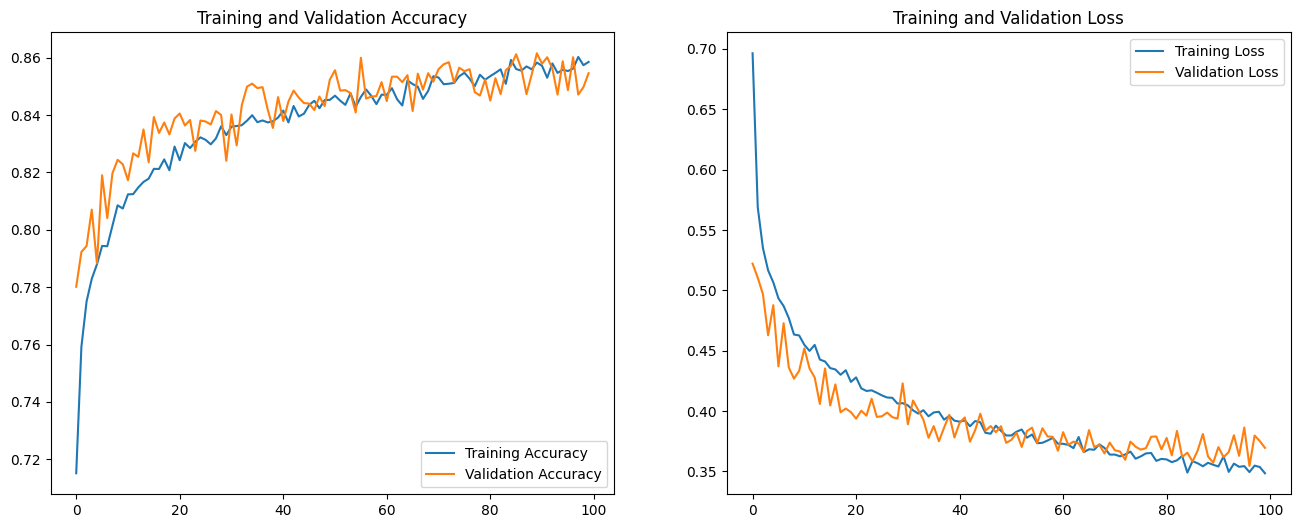

In [7]:
res_luv_pre = train_model('content/img_Luv', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 28s 53ms/step - loss: 2.4140 - accuracy: 0.4644 - val_loss: 0.9285 - val_accuracy: 0.6011
Epoch 2/100
360/360 [==============================] - 17s 46ms/step - loss: 0.9798 - accuracy: 0.5918 - val_loss: 0.8256 - val_accuracy: 0.6521
Epoch 3/100
360/360 [==============================] - 17s 46ms/step - loss: 0.8987 - accuracy: 0.6187 - val_loss: 0.8237 - val_accuracy: 0.6471
Epoch 4/100
360/360 [==============================] - 17s 47ms/step - loss: 0.8599 - accuracy: 0.6362 - val_loss: 0.7391 - val_accuracy: 0.6801
Epoch 5/100
360/360 [==============================] - 17s 48ms/step - loss: 0.8179 - accuracy: 0.6527 - val_loss: 0.7350 - val_accuracy: 0.6841
Epoch 6/100
360/360 [==============================] - 17s 47ms/step - loss: 0.8069 - accuracy: 0.6561 - val_loss: 0.7216 - va

360/360 [==============================] - 17s 47ms/step - loss: 0.6174 - accuracy: 0.7516 - val_loss: 0.5453 - val_accuracy: 0.7791
Epoch 57/100
360/360 [==============================] - 17s 47ms/step - loss: 0.6162 - accuracy: 0.7503 - val_loss: 0.6080 - val_accuracy: 0.7537
Epoch 58/100
360/360 [==============================] - 17s 48ms/step - loss: 0.6148 - accuracy: 0.7525 - val_loss: 0.5736 - val_accuracy: 0.7635
Epoch 59/100
360/360 [==============================] - 17s 48ms/step - loss: 0.6229 - accuracy: 0.7492 - val_loss: 0.5672 - val_accuracy: 0.7741
Epoch 60/100
360/360 [==============================] - 17s 47ms/step - loss: 0.6165 - accuracy: 0.7515 - val_loss: 0.5459 - val_accuracy: 0.7845
Epoch 61/100
360/360 [==============================] - 17s 46ms/step - loss: 0.6125 - accuracy: 0.7529 - val_loss: 0.5436 - val_accuracy: 0.7885
Epoch 62/100
360/360 [==============================] - 17s 47ms/step - loss: 0.6122 - accuracy: 0.7525 - val_loss: 0.5844 - val_accuracy

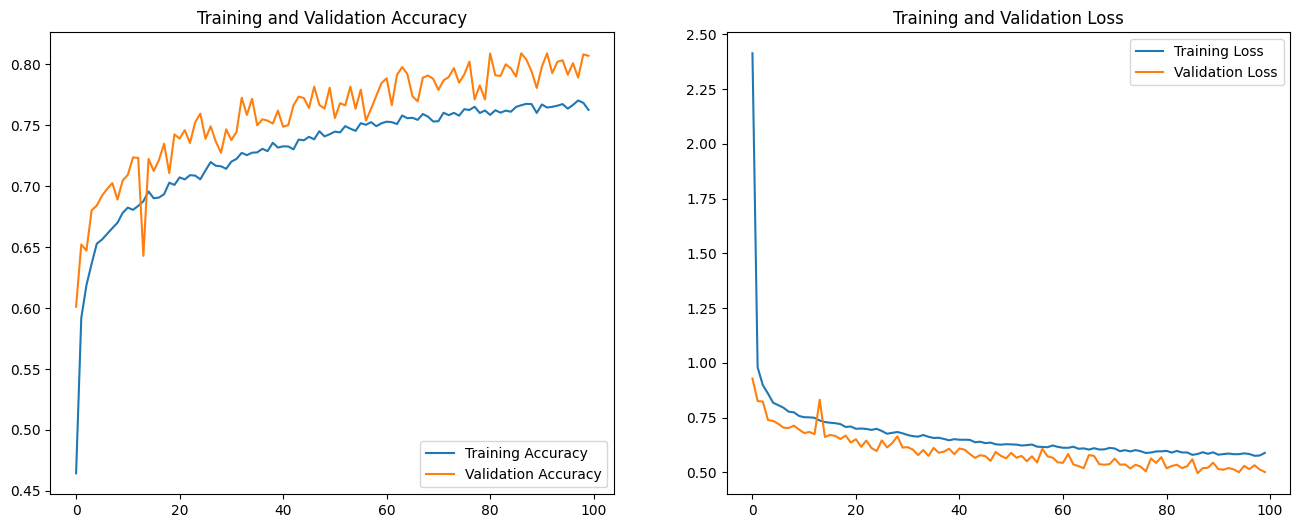

In [8]:
res_luv_nonpre = train_model('content/img_Luv', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 30s 55ms/step - loss: 0.7251 - accuracy: 0.6926 - val_loss: 0.5635 - val_accuracy: 0.7544
Epoch 2/100
360/360 [==============================] - 18s 51ms/step - loss: 0.6063 - accuracy: 0.7367 - val_loss: 0.5550 - val_accuracy: 0.7617
Epoch 3/100
360/360 [==============================] - 18s 49ms/step - loss: 0.5740 - accuracy: 0.7547 - val_loss: 0.5313 - val_accuracy: 0.7727
Epoch 4/100
360/360 [==============================] - 17s 47ms/step - loss: 0.5693 - accuracy: 0.7526 - val_loss: 0.5193 - val_accuracy: 0.7780
Epoch 5/100
360/360 [==============================] - 17s 48ms/step - loss: 0.5453 - accuracy: 0.7657 - val_loss: 0.5289 - val_accuracy: 0.7768
Epoch 6/100
360/360 [==============================] - 17s 48ms/step - loss: 0.5375 - accuracy: 0.7736 - v

360/360 [==============================] - 17s 47ms/step - loss: 0.4421 - accuracy: 0.8178 - val_loss: 0.4375 - val_accuracy: 0.8232
Epoch 57/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4357 - accuracy: 0.8185 - val_loss: 0.4341 - val_accuracy: 0.8230
Epoch 58/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4324 - accuracy: 0.8223 - val_loss: 0.4295 - val_accuracy: 0.8263
Epoch 59/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4317 - accuracy: 0.8219 - val_loss: 0.4249 - val_accuracy: 0.8244
Epoch 60/100
360/360 [==============================] - 17s 48ms/step - loss: 0.4316 - accuracy: 0.8205 - val_loss: 0.4280 - val_accuracy: 0.8239
Epoch 61/100
360/360 [==============================] - 19s 54ms/step - loss: 0.4390 - accuracy: 0.8141 - val_loss: 0.4409 - val_accuracy: 0.8159
Epoch 62/100
360/360 [==============================] - 17s 47ms/step - loss: 0.4351 - accuracy: 0.8198 - val_loss: 0.4344 - val_accuracy

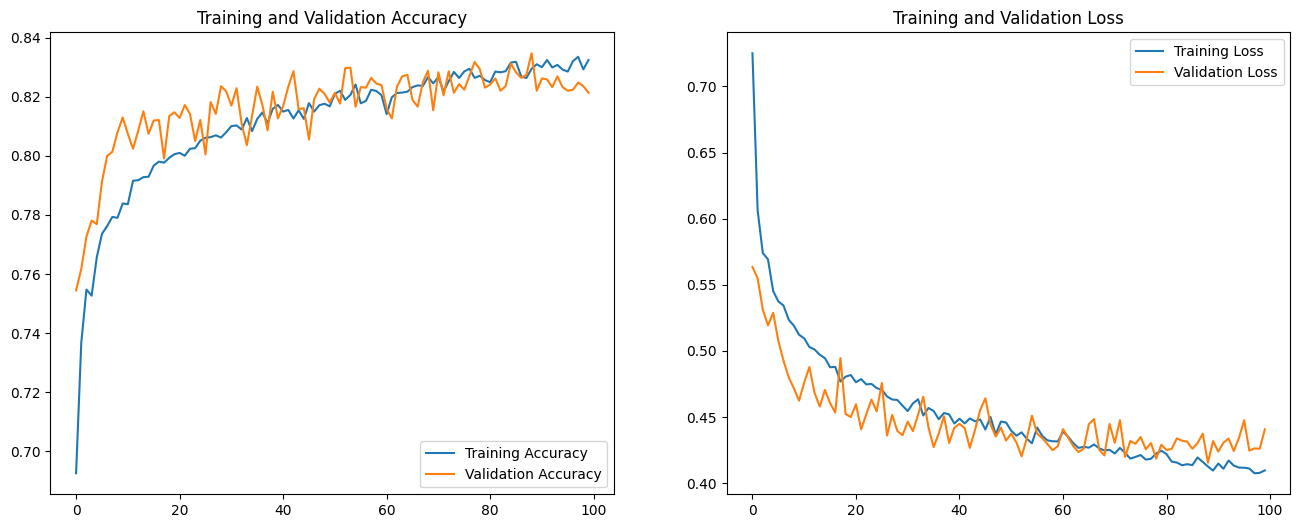

In [9]:
res_ycrcb_pre = train_model('content/img_YCrCb', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 28s 54ms/step - loss: 2.6234 - accuracy: 0.3809 - val_loss: 1.1844 - val_accuracy: 0.4700
Epoch 2/100
360/360 [==============================] - 17s 48ms/step - loss: 1.2019 - accuracy: 0.4597 - val_loss: 1.0473 - val_accuracy: 0.5321
Epoch 3/100
360/360 [==============================] - 18s 50ms/step - loss: 1.1294 - accuracy: 0.5012 - val_loss: 0.9968 - val_accuracy: 0.5422
Epoch 4/100
360/360 [==============================] - 18s 49ms/step - loss: 1.0702 - accuracy: 0.5314 - val_loss: 1.0039 - val_accuracy: 0.5568
Epoch 5/100
360/360 [==============================] - 17s 47ms/step - loss: 1.0392 - accuracy: 0.5442 - val_loss: 0.9560 - val_accuracy: 0.5905
Epoch 6/100
360/360 [==============================] - 17s 47ms/step - loss: 1.0081 - accuracy: 0.5594 - val_loss: 0.9517 - va

360/360 [==============================] - 17s 46ms/step - loss: 0.9328 - accuracy: 0.6057 - val_loss: 0.8307 - val_accuracy: 0.6422
Epoch 57/100
360/360 [==============================] - 17s 46ms/step - loss: 0.9297 - accuracy: 0.6010 - val_loss: 0.8078 - val_accuracy: 0.6702
Epoch 58/100
360/360 [==============================] - 17s 46ms/step - loss: 0.9232 - accuracy: 0.6054 - val_loss: 0.8951 - val_accuracy: 0.6098
Epoch 59/100
360/360 [==============================] - 17s 47ms/step - loss: 0.9323 - accuracy: 0.6057 - val_loss: 0.9095 - val_accuracy: 0.6080
Epoch 60/100
360/360 [==============================] - 17s 47ms/step - loss: 0.9247 - accuracy: 0.6056 - val_loss: 0.8346 - val_accuracy: 0.6495
Epoch 61/100
360/360 [==============================] - 17s 46ms/step - loss: 0.9332 - accuracy: 0.6013 - val_loss: 0.8476 - val_accuracy: 0.6436
Epoch 62/100
360/360 [==============================] - 16s 45ms/step - loss: 0.9225 - accuracy: 0.6075 - val_loss: 0.8235 - val_accuracy

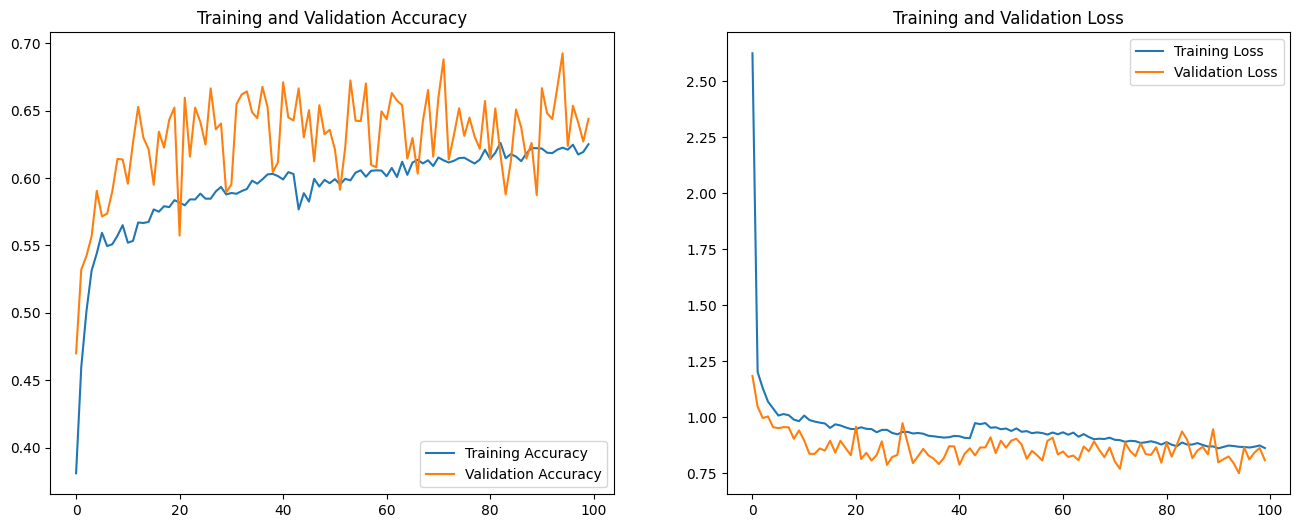

In [10]:
res_ycrcb_nonpre = train_model('content/img_YCrCb', preprocess=False)

In [11]:
pd.DataFrame(res_hls_pre).to_csv("densenet169_nontrainable/res_hls_pre.csv", index=False)
pd.DataFrame(res_hls_nonpre).to_csv("densenet169_nontrainable/res_hls_nonpre.csv", index=False)
pd.DataFrame(res_luv_pre).to_csv("densenet169_nontrainable/res_luv_pre.csv", index=False)
pd.DataFrame(res_luv_nonpre).to_csv("densenet169_nontrainable/res_luv_nonpre.csv", index=False)
pd.DataFrame(res_ycrcb_pre).to_csv("densenet169_nontrainable/res_ycrcb_pre.csv", index=False)
pd.DataFrame(res_ycrcb_nonpre).to_csv("densenet169_nontrainable/res_ycrcb_nonpre.csv", index=False)